# Respiratory Disease Classification using Pure LSTM
## Multi-class Classification (Healthy, COPD, Asthma)

Pipeline lengkap untuk training model LSTM murni (no attention, no bidirectional) menggunakan MFCC features dari audio cough dan vowel.

**Classes:**
- **Class 0: Healthy**
- **Class 1: COPD** 
- **Class 2: Asthma**

## Architecture:
- 2 LSTM layers (unidirectional)
- BatchNorm after each LSTM
- No attention mechanism
- Simple final classification layer

## Pipeline:
1. Load data dari dataclean_cough dan dataclean_vowel
2. Extract MFCC features real-time dari audio files
3. Split berdasarkan train.csv dan test.csv dengan validation split
4. Training pure LSTM model
5. Evaluasi dengan metrics: Accuracy, F1, Recall, Precision, Confusion Matrix
6. Prediction pada test set
7. Save hasil ke CSV

## 1. Import Libraries

In [15]:
import os
import json
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import librosa
from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, 
    f1_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

Using device: cuda


## 2. Configuration

In [16]:
class Config:
    # Paths
    BASE_PATH = Path('/mnt/ml_storage/Final_Project/SOURCE2')
    COUGH_PATH = BASE_PATH / 'dataclean_cough_1'
    VOWEL_PATH = BASE_PATH / 'dataclean_vowel_1'
    TRAIN_CSV = BASE_PATH / 'train.csv'
    TEST_CSV = BASE_PATH / 'test.csv'
    MODEL_DIR = BASE_PATH / 'model'
    
    # Audio parameters
    SAMPLE_RATE = 16000
    DURATION = 1.0
    N_FFT = 2048
    HOP_LENGTH = 512
    WIN_LENGTH = 2048
    N_MFCC = 20
    N_MELS = 64
    
    # Model parameters - PURE LSTM
    INPUT_SIZE = 60  # 20 MFCC + 20 Delta + 20 Delta-Delta
    HIDDEN_SIZE = 128
    OUTPUT_SIZE = 3  # 3 classes: Healthy(0), COPD(1), Asthma(2)
    DROPOUT = 0.3
    
    # Training parameters
    BATCH_SIZE = 16
    LEARNING_RATE = 0.0005
    NUM_EPOCHS = 100
    VAL_SPLIT = 0.2
    PATIENCE = 20
    GRADIENT_CLIP = 1.0
    WEIGHT_DECAY = 1e-3
    
    # Audio combination mode
    COMBINE_MODE = "concat"  # Options: "concat", "average", "cough_only", "vowel_only"
    
config = Config()

# Create model directory
config.MODEL_DIR.mkdir(exist_ok=True)

print("Configuration (PURE LSTM):")
print(f"  Sample Rate: {config.SAMPLE_RATE} Hz")
print(f"  Duration: {config.DURATION} seconds")
print(f"  N_MFCC: {config.N_MFCC}")
print(f"  Input Features: {config.INPUT_SIZE}")
print(f"  Hidden Size: {config.HIDDEN_SIZE}")
print(f"  Output Classes: {config.OUTPUT_SIZE} (0=Healthy, 1=COPD, 2=Asthma)")
print(f"  Batch Size: {config.BATCH_SIZE}")
print(f"  Learning Rate: {config.LEARNING_RATE}")
print(f"  Epochs: {config.NUM_EPOCHS}")
print(f"  Dropout: {config.DROPOUT}")
print(f"  Weight Decay: {config.WEIGHT_DECAY}")
print(f"  Combine Mode: {config.COMBINE_MODE}")

Configuration (PURE LSTM):
  Sample Rate: 16000 Hz
  Duration: 1.0 seconds
  N_MFCC: 20
  Input Features: 60
  Hidden Size: 128
  Output Classes: 3 (0=Healthy, 1=COPD, 2=Asthma)
  Batch Size: 16
  Learning Rate: 0.0005
  Epochs: 100
  Dropout: 0.3
  Weight Decay: 0.001
  Combine Mode: concat


## 3. Pure LSTM Model Architecture

In [17]:
class LSTMAudioClassifierMFCC(nn.Module):
    """Pure LSTM model with 2 layers, batch normalization, no attention"""
    
    def __init__(self, input_size, hidden_size, output_size, dropout=0.1):
        super(LSTMAudioClassifierMFCC, self).__init__()
        
        self.batch_norm1 = nn.BatchNorm1d(input_size)
        self.lstm1 = nn.LSTM(input_size, hidden_size, batch_first=True)
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.lstm2 = nn.LSTM(hidden_size, hidden_size, batch_first=True)
        
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, lengths=None):
        # First LSTM layer with batch norm
        x = x.transpose(1, 2)
        x = self.batch_norm1(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm1(x)
        
        # Second LSTM layer with batch norm
        x = x.transpose(1, 2)
        x = self.batch_norm2(x)
        x = x.transpose(1, 2)
        x, _ = self.lstm2(x)

        # Take last timestep output
        x = x[:, -1, :]
        x = self.dropout(x)
        x = self.fc(x)
        return x


def load_checkpoint(checkpoint_path, model):
    """Load model checkpoint"""
    checkpoint_dict = torch.load(checkpoint_path, weights_only=True, map_location='cpu')
    saved_state_dict = checkpoint_dict['model']
    state_dict = model.state_dict()
    new_state_dict = {}
    
    for k, v in state_dict.items():
        try:
            new_state_dict[k] = saved_state_dict[k]
        except:
            new_state_dict[k] = v
    
    model.load_state_dict(new_state_dict)
    return model


print("Pure LSTM Model Architecture defined!")

Pure LSTM Model Architecture defined!


## 4. MFCC Feature Extraction

In [18]:
def extract_mfcc_features(audio_path, config):
    """
    Extract MFCC features from audio file
    Returns: (n_frames, n_mfcc * 3) array with MFCC, Delta, Delta-Delta
    """
    try:
        # Load audio
        audio, sr = librosa.load(audio_path, sr=config.SAMPLE_RATE, duration=config.DURATION)
        
        # Pad or trim to exact duration
        target_length = int(config.SAMPLE_RATE * config.DURATION)
        if len(audio) < target_length:
            audio = np.pad(audio, (0, target_length - len(audio)), mode='constant')
        else:
            audio = audio[:target_length]
        
        # Extract MFCC
        mfcc = librosa.feature.mfcc(
            y=audio,
            sr=sr,
            n_mfcc=config.N_MFCC,
            n_mels=config.N_MELS,
            n_fft=config.N_FFT,
            hop_length=config.HOP_LENGTH,
            win_length=config.WIN_LENGTH
        )
        
        # Compute deltas
        delta = librosa.feature.delta(mfcc)
        delta2 = librosa.feature.delta(mfcc, order=2)
        
        # Stack features: (n_features, n_frames)
        features = np.vstack([mfcc, delta, delta2])
        
        # Transpose to (n_frames, n_features)
        features = features.T
        
        return features
        
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        # Return zero features as fallback
        n_frames = int(config.DURATION * config.SAMPLE_RATE / config.HOP_LENGTH) + 1
        return np.zeros((n_frames, config.N_MFCC * 3))


print("MFCC Feature extraction function defined!")

MFCC Feature extraction function defined!


## 5. Dataset Class

In [19]:
class RespiratoryDataset(Dataset):
    """Dataset that combines cough and vowel audio features"""
    
    def __init__(self, candidate_ids, labels, config, is_test=False):
        self.candidate_ids = candidate_ids
        self.labels = labels
        self.config = config
        self.is_test = is_test
        self.cough_path = config.COUGH_PATH
        self.vowel_path = config.VOWEL_PATH
    
    def __len__(self):
        return len(self.candidate_ids)
    
    def __getitem__(self, idx):
        candidate_id = self.candidate_ids[idx]
        
        # Construct file paths (files are in subdirectories)
        cough_file = self.cough_path / candidate_id / 'cough.wav'
        vowel_file = self.vowel_path / candidate_id / 'vowel.wav'
        
        # Extract features from both audio files
        cough_features = extract_mfcc_features(str(cough_file), self.config)
        vowel_features = extract_mfcc_features(str(vowel_file), self.config)
        
        # Combine features based on COMBINE_MODE
        if self.config.COMBINE_MODE == "concat":
            # Concatenate along feature dimension
            combined_features = np.concatenate([cough_features, vowel_features], axis=1)
        elif self.config.COMBINE_MODE == "average":
            # Average the features
            combined_features = (cough_features + vowel_features) / 2
        elif self.config.COMBINE_MODE == "cough_only":
            combined_features = cough_features
        elif self.config.COMBINE_MODE == "vowel_only":
            combined_features = vowel_features
        else:
            raise ValueError(f"Unknown COMBINE_MODE: {self.config.COMBINE_MODE}")
        
        # Convert to tensor
        features_tensor = torch.FloatTensor(combined_features)
        
        if self.is_test:
            return features_tensor, candidate_id
        else:
            label = self.labels[idx]
            return features_tensor, label


def collate_fn(batch):
    """Custom collate function for variable length sequences"""
    if len(batch[0]) == 2 and isinstance(batch[0][1], str):
        # Test set (features, candidate_id)
        features = [item[0] for item in batch]
        candidate_ids = [item[1] for item in batch]
        
        # Pad sequences
        features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
        lengths = torch.LongTensor([len(f) for f in features])
        
        return features_padded, candidate_ids, lengths
    else:
        # Train/val set (features, label)
        features = [item[0] for item in batch]
        labels = torch.LongTensor([item[1] for item in batch])
        
        # Pad sequences
        features_padded = nn.utils.rnn.pad_sequence(features, batch_first=True)
        lengths = torch.LongTensor([len(f) for f in features])
        
        return features_padded, labels, lengths


print("Dataset class defined!")

Dataset class defined!


## 6. Load and Prepare Data

In [20]:
# Load train and test CSVs
train_df = pd.read_csv(config.TRAIN_CSV)
test_df = pd.read_csv(config.TEST_CSV)

print(f"Train set: {len(train_df)} samples")
print(f"Test set: {len(test_df)} samples")

# Check class distribution
class_names = ['Healthy', 'COPD', 'Asthma']
print("\nTrain set class distribution:")
for cls in range(3):
    count = (train_df['disease'] == cls).sum()
    pct = count / len(train_df) * 100
    print(f"  {class_names[cls]}: {count} ({pct:.1f}%)")

Train set: 546 samples
Test set: 338 samples

Train set class distribution:
  Healthy: 140 (25.6%)
  COPD: 238 (43.6%)
  Asthma: 168 (30.8%)


In [21]:
# Verify audio files exist
def verify_audio_files(df, cough_path, vowel_path, dataset_name=""):
    missing_cough = []
    missing_vowel = []
    
    for idx, row in df.iterrows():
        candidate_id = row['candidateID']
        cough_file = cough_path / candidate_id / 'cough.wav'
        vowel_file = vowel_path / candidate_id / 'vowel.wav'
        
        if not cough_file.exists():
            missing_cough.append(candidate_id)
        if not vowel_file.exists():
            missing_vowel.append(candidate_id)
    
    print(f"\n{dataset_name} Audio File Verification:")
    print(f"  Missing cough files: {len(missing_cough)}")
    print(f"  Missing vowel files: {len(missing_vowel)}")
    
    return missing_cough, missing_vowel

# Verify train files
train_missing_cough, train_missing_vowel = verify_audio_files(
    train_df, config.COUGH_PATH, config.VOWEL_PATH, "Train Set"
)

# Verify test files
test_missing_cough, test_missing_vowel = verify_audio_files(
    test_df, config.COUGH_PATH, config.VOWEL_PATH, "Test Set"
)

# Remove samples with missing files
train_missing_ids = set(train_missing_cough + train_missing_vowel)
test_missing_ids = set(test_missing_cough + test_missing_vowel)

if len(train_missing_ids) > 0:
    print(f"\nRemoving {len(train_missing_ids)} train samples with missing audio files")
    train_df_filtered = train_df[~train_df['candidateID'].isin(train_missing_ids)].reset_index(drop=True)
else:
    train_df_filtered = train_df

print(f"\nFinal train set: {len(train_df_filtered)} samples")


Train Set Audio File Verification:
  Missing cough files: 6
  Missing vowel files: 12

Test Set Audio File Verification:
  Missing cough files: 0
  Missing vowel files: 2

Removing 12 train samples with missing audio files

Final train set: 533 samples


In [22]:
# Split train into train and validation
train_ids = train_df_filtered['candidateID'].values
train_labels = train_df_filtered['disease'].values

train_ids, val_ids, train_labels, val_labels = train_test_split(
    train_ids, train_labels,
    test_size=config.VAL_SPLIT,
    random_state=42,
    stratify=train_labels
)

print(f"\nData split:")
print(f"  Train: {len(train_ids)} samples")
print(f"  Validation: {len(val_ids)} samples")
print(f"  Test: {len(test_df)} samples")


Data split:
  Train: 426 samples
  Validation: 107 samples
  Test: 338 samples


## 7. Create Datasets and Dataloaders

In [23]:
# Adjust input size based on combine mode
if config.COMBINE_MODE == "concat":
    actual_input_size = config.INPUT_SIZE * 2  # 120 features (60 cough + 60 vowel)
else:
    actual_input_size = config.INPUT_SIZE  # 60 features

print(f"Actual input size for {config.COMBINE_MODE} mode: {actual_input_size}")

# Create datasets
train_dataset = RespiratoryDataset(train_ids, train_labels, config, is_test=False)
val_dataset = RespiratoryDataset(val_ids, val_labels, config, is_test=False)
test_dataset = RespiratoryDataset(test_df['candidateID'].values, None, config, is_test=True)

# Create dataloaders
train_loader = DataLoader(
    train_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0,
    pin_memory=True if torch.cuda.is_available() else False
)

test_loader = DataLoader(
    test_dataset,
    batch_size=config.BATCH_SIZE,
    shuffle=False,
    collate_fn=collate_fn,
    num_workers=0
)

print(f"\nDataloaders created:")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Actual input size for concat mode: 120

Dataloaders created:
  Train batches: 27
  Val batches: 7
  Test batches: 22


## 8. Initialize Model and Training Components

In [24]:
# Initialize model
model = LSTMAudioClassifierMFCC(
    input_size=actual_input_size,
    hidden_size=config.HIDDEN_SIZE,
    output_size=config.OUTPUT_SIZE,
    dropout=config.DROPOUT
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("\nModel initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,}")
print(f"\nModel architecture:")
print(model)


Model initialized:
  Total parameters: 260,979
  Trainable parameters: 260,979

Model architecture:
LSTMAudioClassifierMFCC(
  (batch_norm1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm1): LSTM(120, 128, batch_first=True)
  (batch_norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lstm2): LSTM(128, 128, batch_first=True)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=128, out_features=3, bias=True)
)


In [25]:
# Compute class weights for imbalanced dataset
def compute_class_weights(labels, method='sqrt'):
    """Compute class weights for imbalanced dataset"""
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    total_samples = len(labels)
    num_classes = len(unique_classes)
    
    if method == 'balanced':
        class_weights = total_samples / (num_classes * class_counts)
    elif method == 'sqrt':
        max_count = class_counts.max()
        class_weights = np.sqrt(max_count / class_counts)
    else:
        class_weights = np.ones(num_classes)
    
    print(f"\nClass weights (method='{method}'):")
    class_names = ['Healthy', 'COPD', 'Asthma']
    for cls, count, weight in zip(unique_classes, class_counts, class_weights):
        percentage = count / total_samples * 100
        print(f"  {class_names[int(cls)]}: count={count}, pct={percentage:.1f}%, weight={weight:.4f}")
    
    return torch.FloatTensor(class_weights)

# Compute class weights
class_weights = compute_class_weights(train_labels, method='sqrt')
class_weights = class_weights.to(device)

# Loss function with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1)

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Learning rate scheduler
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=10, T_mult=2, eta_min=1e-6
)

print("\nTraining components initialized:")
print(f"  Loss: CrossEntropyLoss with class weights and label smoothing")
print(f"  Optimizer: AdamW (lr={config.LEARNING_RATE}, weight_decay={config.WEIGHT_DECAY})")
print(f"  Scheduler: CosineAnnealingWarmRestarts")


Class weights (method='sqrt'):
  Healthy: count=110, pct=25.8%, weight=1.3143
  COPD: count=190, pct=44.6%, weight=1.0000
  Asthma: count=126, pct=29.6%, weight=1.2280

Training components initialized:
  Loss: CrossEntropyLoss with class weights and label smoothing
  Optimizer: AdamW (lr=0.0005, weight_decay=0.001)
  Scheduler: CosineAnnealingWarmRestarts

Training components initialized:
  Loss: CrossEntropyLoss with class weights and label smoothing
  Optimizer: AdamW (lr=0.0005, weight_decay=0.001)
  Scheduler: CosineAnnealingWarmRestarts


## 9. Training Functions

In [26]:
def train_epoch(model, train_loader, criterion, optimizer, device, config):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    pbar = tqdm(train_loader, desc='Training')
    for features, labels, lengths in pbar:
        features = features.to(device)
        labels = labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(features, lengths)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), config.GRADIENT_CLIP)
        optimizer.step()
        
        # Track metrics
        total_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())
        
        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    avg_loss = total_loss / len(train_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    
    return avg_loss, accuracy, f1


def validate_epoch(model, val_loader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for features, labels, lengths in tqdm(val_loader, desc='Validation'):
            features = features.to(device)
            labels = labels.to(device)
            
            outputs = model(features, lengths)
            loss = criterion(outputs, labels)
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    avg_loss = total_loss / len(val_loader)
    accuracy = accuracy_score(all_labels, all_preds)
    f1 = f1_score(all_labels, all_preds, average='weighted')
    recall = recall_score(all_labels, all_preds, average='weighted')
    precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
    
    return avg_loss, accuracy, f1, recall, precision, all_preds, all_labels


print("Training functions defined!")

Training functions defined!


## 10. Training Loop

In [27]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'train_f1': [],
    'val_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_recall': [],
    'val_precision': [],
    'learning_rate': []
}

best_val_f1 = 0
best_val_loss = float('inf')
patience_counter = 0

print(f"\nStarting training for {config.NUM_EPOCHS} epochs...")
print(f"{'='*70}")

for epoch in range(config.NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{config.NUM_EPOCHS}")
    print(f"{'-'*70}")
    
    # Train
    train_loss, train_acc, train_f1 = train_epoch(
        model, train_loader, criterion, optimizer, device, config
    )
    
    # Validate
    val_loss, val_acc, val_f1, val_recall, val_precision, _, _ = validate_epoch(
        model, val_loader, criterion, device
    )
    
    # Update scheduler
    scheduler.step()
    current_lr = optimizer.param_groups[0]['lr']
    
    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['train_f1'].append(train_f1)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['val_f1'].append(val_f1)
    history['val_recall'].append(val_recall)
    history['val_precision'].append(val_precision)
    history['learning_rate'].append(current_lr)
    
    # Print metrics
    print(f"\nResults:")
    print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc:.4f}, F1: {train_f1:.4f}")
    print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc:.4f}, F1: {val_f1:.4f}")
    print(f"  Val   - Recall: {val_recall:.4f}, Precision: {val_precision:.4f}")
    print(f"  Learning Rate: {current_lr:.6f}")
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_val_loss = val_loss
        patience_counter = 0
        
        # Save checkpoint
        checkpoint_path = config.MODEL_DIR / 'pure_lstm_best.pth'
        torch.save({
            'epoch': epoch,
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict(),
            'val_f1': val_f1,
            'val_loss': val_loss,
            'history': history,
            'config': config
        }, checkpoint_path)
        
        print(f"  ✓ New best model saved! (F1: {val_f1:.4f})")
    else:
        patience_counter += 1
        print(f"  Patience: {patience_counter}/{config.PATIENCE}")
    
    # Early stopping
    if patience_counter >= config.PATIENCE:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

print(f"\n{'='*70}")
print(f"Training completed!")
print(f"Best validation F1: {best_val_f1:.4f}")
print(f"Best validation loss: {best_val_loss:.4f}")


Starting training for 100 epochs...

Epoch 1/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:01<00:00,  6.83it/s]



Results:
  Train - Loss: 1.0978, Acc: 0.3991, F1: 0.3611
  Val   - Loss: 1.0859, Acc: 0.4486, F1: 0.3709
  Val   - Recall: 0.4486, Precision: 0.4005
  Learning Rate: 0.000488
  ✓ New best model saved! (F1: 0.3709)

Epoch 2/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.35it/s]




Results:
  Train - Loss: 0.9916, Acc: 0.6009, F1: 0.6010
  Val   - Loss: 1.0784, Acc: 0.3925, F1: 0.3779
  Val   - Recall: 0.3925, Precision: 0.3807
  Learning Rate: 0.000452
  ✓ New best model saved! (F1: 0.3779)

Epoch 3/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.30it/s]



Results:
  Train - Loss: 0.8799, Acc: 0.6714, F1: 0.6686
  Val   - Loss: 1.0933, Acc: 0.4019, F1: 0.3942
  Val   - Recall: 0.4019, Precision: 0.3973
  Learning Rate: 0.000397
  ✓ New best model saved! (F1: 0.3942)

Epoch 4/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.69it/s]




Results:
  Train - Loss: 0.7575, Acc: 0.7512, F1: 0.7523
  Val   - Loss: 1.1462, Acc: 0.4112, F1: 0.4034
  Val   - Recall: 0.4112, Precision: 0.4041
  Learning Rate: 0.000328
  ✓ New best model saved! (F1: 0.4034)

Epoch 5/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.31it/s]




Results:
  Train - Loss: 0.6366, Acc: 0.8427, F1: 0.8429
  Val   - Loss: 1.2421, Acc: 0.4299, F1: 0.4250
  Val   - Recall: 0.4299, Precision: 0.4235
  Learning Rate: 0.000251
  ✓ New best model saved! (F1: 0.4250)

Epoch 6/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.28it/s]



Results:
  Train - Loss: 0.5498, Acc: 0.8920, F1: 0.8918
  Val   - Loss: 1.2811, Acc: 0.4299, F1: 0.4268
  Val   - Recall: 0.4299, Precision: 0.4324
  Learning Rate: 0.000173
  ✓ New best model saved! (F1: 0.4268)

Epoch 7/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.11it/s]



Results:
  Train - Loss: 0.4821, Acc: 0.9366, F1: 0.9368
  Val   - Loss: 1.3424, Acc: 0.4206, F1: 0.4173
  Val   - Recall: 0.4206, Precision: 0.4154
  Learning Rate: 0.000104
  Patience: 1/20

Epoch 8/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.84it/s]



Results:
  Train - Loss: 0.4489, Acc: 0.9554, F1: 0.9554
  Val   - Loss: 1.3756, Acc: 0.4299, F1: 0.4259
  Val   - Recall: 0.4299, Precision: 0.4238
  Learning Rate: 0.000049
  Patience: 2/20

Epoch 9/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00,  9.99it/s]



Results:
  Train - Loss: 0.4274, Acc: 0.9507, F1: 0.9507
  Val   - Loss: 1.3876, Acc: 0.4112, F1: 0.4074
  Val   - Recall: 0.4112, Precision: 0.4077
  Learning Rate: 0.000013
  Patience: 3/20

Epoch 10/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.42it/s]



Results:
  Train - Loss: 0.4128, Acc: 0.9671, F1: 0.9671
  Val   - Loss: 1.3779, Acc: 0.4019, F1: 0.4000
  Val   - Recall: 0.4019, Precision: 0.4011
  Learning Rate: 0.000500
  Patience: 4/20

Epoch 11/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.92it/s]




Results:
  Train - Loss: 0.4127, Acc: 0.9531, F1: 0.9531
  Val   - Loss: 1.4997, Acc: 0.4393, F1: 0.4417
  Val   - Recall: 0.4393, Precision: 0.4480
  Learning Rate: 0.000497
  ✓ New best model saved! (F1: 0.4417)

Epoch 12/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.19it/s]



Results:
  Train - Loss: 0.3695, Acc: 0.9859, F1: 0.9859
  Val   - Loss: 1.5654, Acc: 0.4299, F1: 0.4274
  Val   - Recall: 0.4299, Precision: 0.4257
  Learning Rate: 0.000488
  Patience: 1/20

Epoch 13/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.59it/s]



Results:
  Train - Loss: 0.3476, Acc: 0.9906, F1: 0.9906
  Val   - Loss: 1.5585, Acc: 0.4299, F1: 0.4307
  Val   - Recall: 0.4299, Precision: 0.4317
  Learning Rate: 0.000473
  Patience: 2/20

Epoch 14/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]



Results:
  Train - Loss: 0.3393, Acc: 0.9906, F1: 0.9906
  Val   - Loss: 1.5319, Acc: 0.3925, F1: 0.3911
  Val   - Recall: 0.3925, Precision: 0.3961
  Learning Rate: 0.000452
  Patience: 3/20

Epoch 15/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.85it/s]



Results:
  Train - Loss: 0.3327, Acc: 0.9953, F1: 0.9953
  Val   - Loss: 1.5685, Acc: 0.4299, F1: 0.4254
  Val   - Recall: 0.4299, Precision: 0.4265
  Learning Rate: 0.000427
  Patience: 4/20

Epoch 16/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.89it/s]



Results:
  Train - Loss: 0.3253, Acc: 0.9977, F1: 0.9977
  Val   - Loss: 1.4969, Acc: 0.4953, F1: 0.4730
  Val   - Recall: 0.4953, Precision: 0.4695
  Learning Rate: 0.000397
  ✓ New best model saved! (F1: 0.4730)

Epoch 17/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.83it/s]



Results:
  Train - Loss: 0.3248, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.5211, Acc: 0.3925, F1: 0.3923
  Val   - Recall: 0.3925, Precision: 0.3939
  Learning Rate: 0.000364
  Patience: 1/20

Epoch 18/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.86it/s]



Results:
  Train - Loss: 0.3139, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4805, Acc: 0.4112, F1: 0.4092
  Val   - Recall: 0.4112, Precision: 0.4074
  Learning Rate: 0.000328
  Patience: 2/20

Epoch 19/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.00it/s]



Results:
  Train - Loss: 0.3121, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.5039, Acc: 0.4206, F1: 0.4187
  Val   - Recall: 0.4206, Precision: 0.4191
  Learning Rate: 0.000290
  Patience: 3/20

Epoch 20/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.31it/s]



Results:
  Train - Loss: 0.3139, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4781, Acc: 0.3925, F1: 0.3863
  Val   - Recall: 0.3925, Precision: 0.3848
  Learning Rate: 0.000251
  Patience: 4/20

Epoch 21/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.36it/s]



Results:
  Train - Loss: 0.3129, Acc: 0.9977, F1: 0.9977
  Val   - Loss: 1.4314, Acc: 0.4299, F1: 0.4264
  Val   - Recall: 0.4299, Precision: 0.4242
  Learning Rate: 0.000211
  Patience: 5/20

Epoch 22/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.46it/s]



Results:
  Train - Loss: 0.3097, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4313, Acc: 0.4393, F1: 0.4388
  Val   - Recall: 0.4393, Precision: 0.4388
  Learning Rate: 0.000173
  Patience: 6/20

Epoch 23/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.86it/s]



Results:
  Train - Loss: 0.3091, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4514, Acc: 0.4393, F1: 0.4376
  Val   - Recall: 0.4393, Precision: 0.4368
  Learning Rate: 0.000137
  Patience: 7/20

Epoch 24/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.48it/s]



Results:
  Train - Loss: 0.3085, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4575, Acc: 0.4486, F1: 0.4510
  Val   - Recall: 0.4486, Precision: 0.4548
  Learning Rate: 0.000104
  Patience: 8/20

Epoch 25/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.25it/s]



Results:
  Train - Loss: 0.3092, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4577, Acc: 0.4299, F1: 0.4297
  Val   - Recall: 0.4299, Precision: 0.4312
  Learning Rate: 0.000074
  Patience: 9/20

Epoch 26/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 13.54it/s]



Results:
  Train - Loss: 0.3077, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4373, Acc: 0.4206, F1: 0.4191
  Val   - Recall: 0.4206, Precision: 0.4197
  Learning Rate: 0.000049
  Patience: 10/20

Epoch 27/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.01it/s]



Results:
  Train - Loss: 0.3075, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4418, Acc: 0.4206, F1: 0.4199
  Val   - Recall: 0.4206, Precision: 0.4205
  Learning Rate: 0.000028
  Patience: 11/20

Epoch 28/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.42it/s]



Results:
  Train - Loss: 0.3071, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4522, Acc: 0.4206, F1: 0.4162
  Val   - Recall: 0.4206, Precision: 0.4148
  Learning Rate: 0.000013
  Patience: 12/20

Epoch 29/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.01it/s]



Results:
  Train - Loss: 0.3076, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4405, Acc: 0.4299, F1: 0.4280
  Val   - Recall: 0.4299, Precision: 0.4274
  Learning Rate: 0.000004
  Patience: 13/20

Epoch 30/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 10.02it/s]



Results:
  Train - Loss: 0.3068, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4411, Acc: 0.4299, F1: 0.4295
  Val   - Recall: 0.4299, Precision: 0.4298
  Learning Rate: 0.000500
  Patience: 14/20

Epoch 31/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.15it/s]



Results:
  Train - Loss: 0.3078, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4443, Acc: 0.4299, F1: 0.4274
  Val   - Recall: 0.4299, Precision: 0.4253
  Learning Rate: 0.000499
  Patience: 15/20

Epoch 32/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 11.17it/s]



Results:
  Train - Loss: 0.3114, Acc: 0.9977, F1: 0.9977
  Val   - Loss: 1.4447, Acc: 0.4299, F1: 0.4258
  Val   - Recall: 0.4299, Precision: 0.4235
  Learning Rate: 0.000497
  Patience: 16/20

Epoch 33/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.07it/s]



Results:
  Train - Loss: 0.3106, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.5408, Acc: 0.4112, F1: 0.4103
  Val   - Recall: 0.4112, Precision: 0.4125
  Learning Rate: 0.000493
  Patience: 17/20

Epoch 34/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.51it/s]



Results:
  Train - Loss: 0.3146, Acc: 0.9977, F1: 0.9977
  Val   - Loss: 1.4274, Acc: 0.4673, F1: 0.4569
  Val   - Recall: 0.4673, Precision: 0.4535
  Learning Rate: 0.000488
  Patience: 18/20

Epoch 35/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.49it/s]



Results:
  Train - Loss: 0.3110, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4473, Acc: 0.4579, F1: 0.4622
  Val   - Recall: 0.4579, Precision: 0.4697
  Learning Rate: 0.000481
  Patience: 19/20

Epoch 36/100
----------------------------------------------------------------------


Validation: 100%|██████████| 7/7 [00:00<00:00, 12.74it/s]


Results:
  Train - Loss: 0.3091, Acc: 1.0000, F1: 1.0000
  Val   - Loss: 1.4849, Acc: 0.4206, F1: 0.4134
  Val   - Recall: 0.4206, Precision: 0.4091
  Learning Rate: 0.000473
  Patience: 20/20

Early stopping triggered after 36 epochs

Training completed!
Best validation F1: 0.4730
Best validation loss: 1.4969


## 11. Plot Training History

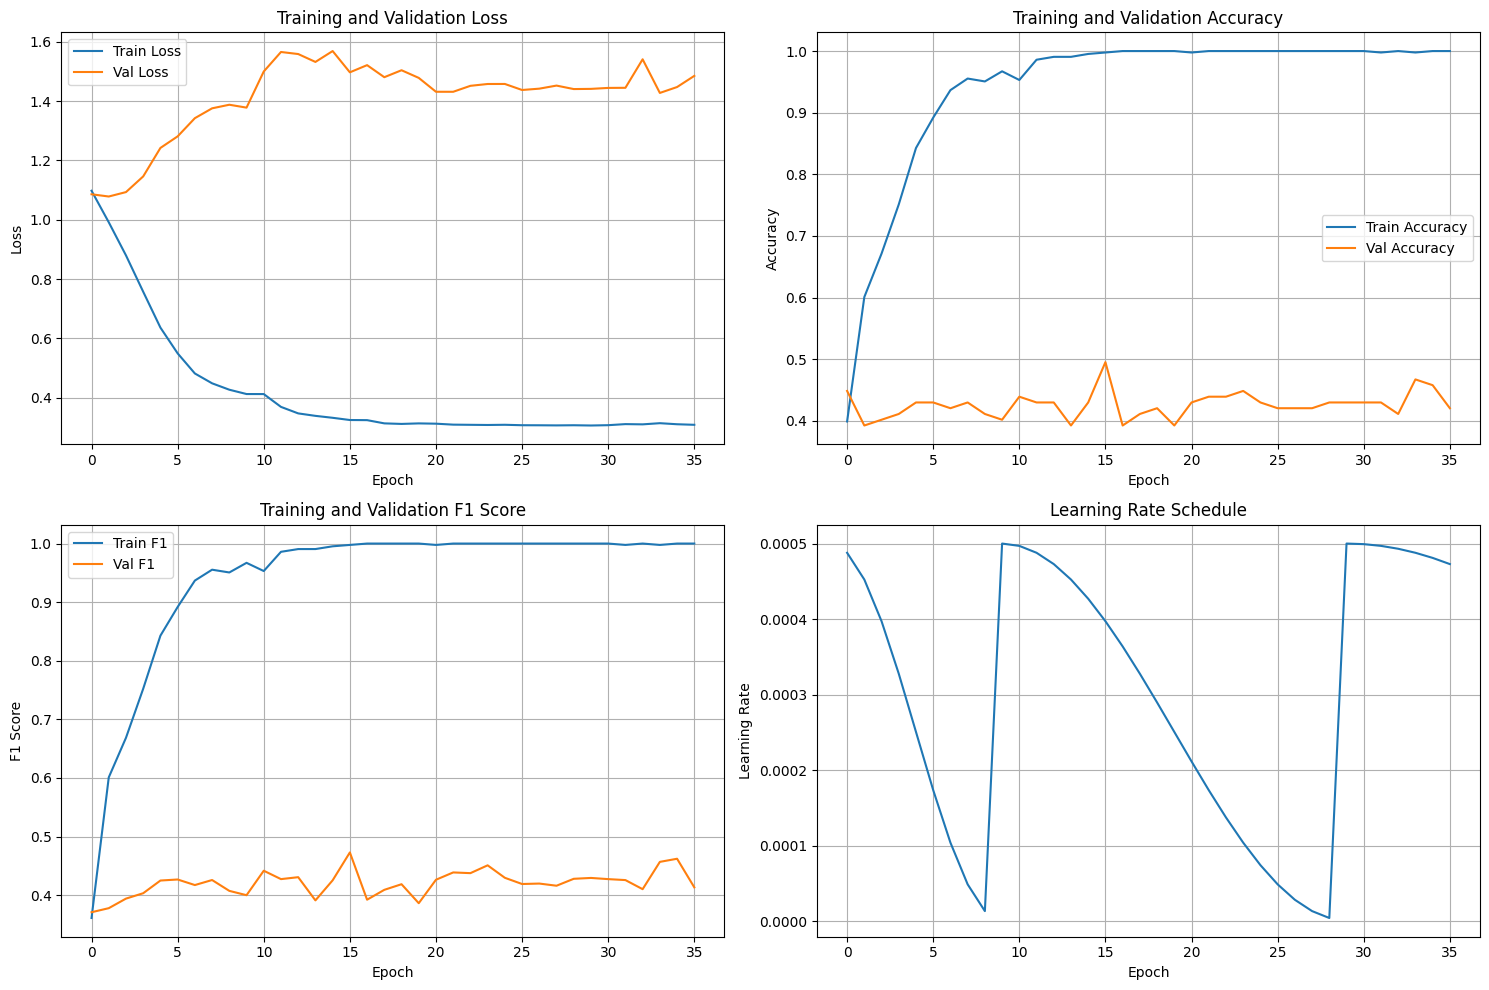

Training history plotted and saved!


In [28]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Loss
axes[0, 0].plot(history['train_loss'], label='Train Loss')
axes[0, 0].plot(history['val_loss'], label='Val Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Validation Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Accuracy
axes[0, 1].plot(history['train_acc'], label='Train Accuracy')
axes[0, 1].plot(history['val_acc'], label='Val Accuracy')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Training and Validation Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# F1 Score
axes[1, 0].plot(history['train_f1'], label='Train F1')
axes[1, 0].plot(history['val_f1'], label='Val F1')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('Training and Validation F1 Score')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Learning Rate
axes[1, 1].plot(history['learning_rate'])
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Learning Rate')
axes[1, 1].set_title('Learning Rate Schedule')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(config.MODEL_DIR / 'pure_lstm_training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print("Training history plotted and saved!")

## 12. Evaluate Best Model

In [ ]:
# Load best model
checkpoint = torch.load(config.MODEL_DIR / 'pure_lstm_best.pth', weights_only=False)
model.load_state_dict(checkpoint['model'])
print(f"Loaded best model from epoch {checkpoint['epoch']+1}")
print(f"Best Val F1: {checkpoint['val_f1']:.4f}")

# Evaluate on validation set
val_loss, val_acc, val_f1, val_recall, val_precision, val_preds, val_labels = validate_epoch(
    model, val_loader, criterion, device
)

print(f"\nValidation Set Performance:")
print(f"  Loss: {val_loss:.4f}")
print(f"  Accuracy: {val_acc:.4f}")
print(f"  F1 Score: {val_f1:.4f}")
print(f"  Recall: {val_recall:.4f}")
print(f"  Precision: {val_precision:.4f}")

UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, [1mdo those steps only if you trust the source of the checkpoint[0m. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL __main__.Config was not an allowed global by default. Please use `torch.serialization.add_safe_globals([Config])` or the `torch.serialization.safe_globals([Config])` context manager to allowlist this global if you trust this class/function.

Check the documentation of torch.load to learn more about types accepted by default with weights_only https://pytorch.org/docs/stable/generated/torch.load.html.

In [ ]:
# Classification report
class_names = ['Healthy', 'COPD', 'Asthma']
print("\nClassification Report:")
print(classification_report(val_labels, val_preds, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_labels, val_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Validation Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(config.MODEL_DIR / 'pure_lstm_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("Confusion matrix saved!")

## 13. Generate Test Predictions

In [ ]:
# Generate predictions on test set
model.eval()
test_predictions = []
test_candidate_ids = []

print("Generating predictions on test set...")
with torch.no_grad():
    for features, candidate_ids, lengths in tqdm(test_loader, desc='Predicting'):
        features = features.to(device)
        outputs = model(features, lengths)
        _, predicted = torch.max(outputs, 1)
        
        test_predictions.extend(predicted.cpu().numpy())
        test_candidate_ids.extend(candidate_ids)

print(f"Generated {len(test_predictions)} predictions")

In [ ]:
# Create submission dataframe
submission_df = pd.DataFrame({
    'candidateID': test_candidate_ids,
    'disease': test_predictions
})

# Sort by candidateID
submission_df = submission_df.sort_values('candidateID').reset_index(drop=True)

# Save to CSV
submission_path = config.BASE_PATH / 'submission_pure_lstm.csv'
submission_df.to_csv(submission_path, index=False)

print(f"\nSubmission file saved to: {submission_path}")
print(f"\nPrediction distribution:")
for cls in range(3):
    count = (submission_df['disease'] == cls).sum()
    pct = count / len(submission_df) * 100
    print(f"  {class_names[cls]}: {count} ({pct:.1f}%)")

print(f"\nFirst few predictions:")
print(submission_df.head(10))

## 14. Summary

In [ ]:
print("="*70)
print("PURE LSTM MODEL TRAINING SUMMARY")
print("="*70)
print(f"\nModel Architecture:")
print(f"  - 2 LSTM layers (unidirectional)")
print(f"  - BatchNorm after each LSTM")
print(f"  - No attention mechanism")
print(f"  - Hidden size: {config.HIDDEN_SIZE}")
print(f"  - Dropout: {config.DROPOUT}")
print(f"  - Total parameters: {total_params:,}")
print(f"\nTraining Configuration:")
print(f"  - Batch size: {config.BATCH_SIZE}")
print(f"  - Learning rate: {config.LEARNING_RATE}")
print(f"  - Weight decay: {config.WEIGHT_DECAY}")
print(f"  - Epochs trained: {len(history['train_loss'])}")
print(f"\nBest Results:")
print(f"  - Validation F1: {best_val_f1:.4f}")
print(f"  - Validation Loss: {best_val_loss:.4f}")
print(f"\nFiles Saved:")
print(f"  - Model: {config.MODEL_DIR / 'pure_lstm_best.pth'}")
print(f"  - Submission: {submission_path}")
print(f"  - Training history plot: {config.MODEL_DIR / 'pure_lstm_training_history.png'}")
print(f"  - Confusion matrix: {config.MODEL_DIR / 'pure_lstm_confusion_matrix.png'}")
print("="*70)